In [1]:
import os
import copy
import functools
from collections import defaultdict

import lmfit
import corner
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy.stats import linregress
from matplotlib.ticker import MultipleLocator
from lmfit import Parameter, Parameters

import sivqed.models.fitter as fitter
from sivqed.models.cavity import Cavity, MultiQubitCavity
from sivqed.models.fitter import cavity_ref_model, single_siv_ref_model, mcmc
from sivqed.models.fitter import single_siv_ref, two_siv_ref, cavity_ref, three_siv_ref
from sivqed.models.diffusion import diffused_siv_peaks, plot_diffused_contrasts

np.set_printoptions(precision=4)
plt.rcParams['font.size'] = 18
plt.rcParams['figure.figsize'] = [8, 5]

In [2]:
cavity_path = "../data/20210903_Bb02_cavity/"
cavity_files = ["cavity_scan_raw-counts_x_15_40_14.txt", "cavity_scan_raw-counts_15_40_14.txt"]

# Plotting Cavity

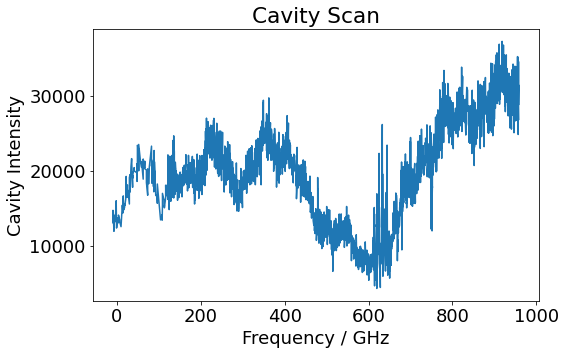

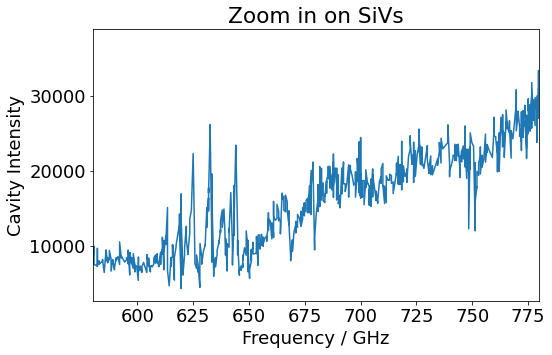

In [3]:
plt.figure(figsize=[8, 5])

cavity_freqs = np.loadtxt(cavity_path + cavity_files[0])
cavity_intensity = np.loadtxt(cavity_path + cavity_files[1])

cavity_freqs = 1000 * (cavity_freqs - 406) # Re-center, convert to GHz
plt.plot(cavity_freqs, cavity_intensity)
plt.xlabel("Frequency / GHz")
plt.ylabel("Cavity Intensity")
plt.title("Cavity Scan")

plt.figure(figsize=[8, 5])
plt.plot(cavity_freqs, cavity_intensity)
plt.xlim(580, 780)
plt.xlabel("Frequency / GHz")
plt.ylabel("Cavity Intensity")
plt.title("Zoom in on SiVs")


cavity_freqs, cavity_intensity = np.array(cavity_freqs), np.array(cavity_intensity)

## Unfiltered Cavity

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 23
    # data points      = 4240
    # variables        = 4
    chi-square         = 7.8925e+10
    reduced chi-square = 18631926.2
    Akaike info crit   = 70983.2395
    Bayesian info crit = 71008.6488
[[Variables]]
    w_c:    584.333058 +/- 1.35571845 (0.23%) (init = 610)
    k_in:   23.9368818 +/- 0.54743861 (2.29%) (init = 100)
    k_tot:  119.522391 +/- 3.47026340 (2.90%) (init = 200)
    A:      25184.6929 +/- 158.915998 (0.63%) (init = 30000)
    B:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, A)     =  0.833
    C(k_in, k_tot) =  0.763
    C(k_tot, A)    =  0.736


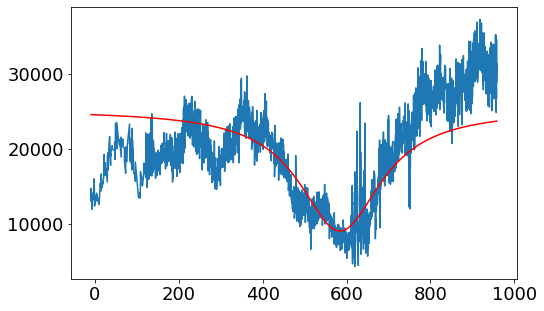

In [4]:
params = Parameters()
params.add_many(
    Parameter('w_c', value=610, min=580, max=620),
    Parameter('k_in', value=100, min=0, max=1000),
    Parameter('k_tot', value=200, min=0, max=1000),
    Parameter('A', value=30000, min=10000, max=75000),
    Parameter('B', value=0, vary=False),
)

cavity_results = cavity_ref_model.fit(cavity_intensity, params, w=cavity_freqs)
lmfit.report_fit(cavity_results)

plt.plot(cavity_freqs, cavity_intensity)
plt.plot(cavity_freqs, cavity_ref_model.eval(params=cavity_results.params, w=cavity_freqs), 'r')

## Filtered Cavity

In [5]:
def not_in_range(arr, ranges):
    """ Returns indices of `arr` that do not lie in the list 
        of (start, end) tuples in ranges. """
    
    conditions = []
    # AND of (x < start OR x > end) leads to all x that are 
    # outside of the (start, end) ranges.
    for start, end in ranges:
        conditions.append((arr < start) | (arr > end)) 
    return np.where(functools.reduce(np.logical_and, conditions))

### Filter cavity tails

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 215
    # data points      = 2164
    # variables        = 4
    chi-square         = 1.0540e+10
    reduced chi-square = 4879610.87
    Akaike info crit   = 33330.8428
    Bayesian info crit = 33353.5617
[[Variables]]
    w_c:    570.729207 +/- 0.58580475 (0.10%) (init = 610)
    k_in:   176.892459 +/- 5.20121752 (2.94%) (init = 100)
    k_tot:  251.371036 +/- 8.31877750 (3.31%) (init = 200)
    A:      52987.4770 +/- 1838.44595 (3.47%) (init = 30000)
    B:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, k_tot) =  0.997
    C(k_tot, A)    =  0.980
    C(k_in, A)     =  0.965
    C(w_c, A)      =  0.101


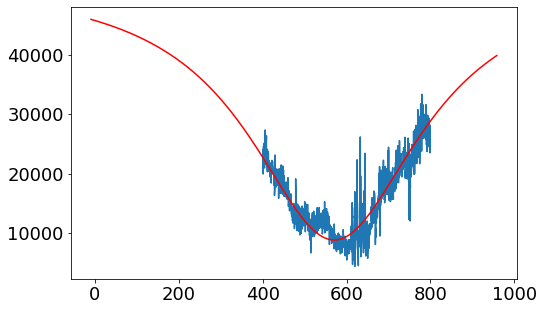

In [6]:
# Range of frequencies to filter out to remove cavity tails
filter_range = [(-20, 400), (800, 1000)]

# Filter the freq and intensity values
filtered_indices = not_in_range(cavity_freqs, filter_range)
cavity_freqs_filtered = cavity_freqs[filtered_indices]
cavity_intensity_filtered = cavity_intensity[filtered_indices]

#####
params = Parameters()
params.add_many(
    Parameter('w_c', value=610, min=550, max=620),
    Parameter('k_in', value=100, min=0, max=1000),
    Parameter('k_tot', value=200, min=0, max=1000),
    Parameter('A', value=30000, min=10000, max=75000),
    Parameter('B', value=0, vary=False),
)

cavity_filtered_results = cavity_ref_model.fit(cavity_intensity_filtered, params, w=cavity_freqs_filtered, method="lbfgsb")
lmfit.report_fit(cavity_filtered_results)

plt.plot(cavity_freqs_filtered, cavity_intensity_filtered)
plt.plot(cavity_freqs, cavity_ref_model.eval(params=cavity_filtered_results.params, w=cavity_freqs), 'r')

### Filter SiVs

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 230
    # data points      = 1779
    # variables        = 4
    chi-square         = 3.3207e+10
    reduced chi-square = 18708333.6
    Akaike info crit   = 29792.4248
    Bayesian info crit = 29814.3600
##  Warning: uncertainties could not be estimated:
    w_c:    at initial value
    w_c:    at boundary
[[Variables]]
    w_c:    610.000000 +/-        nan (nan%) (init = 610)
    k_in:   239.624240 +/- 33.0800583 (13.80%) (init = 100)
    k_tot:  353.983606 +/- 58.3674854 (16.49%) (init = 200)
    A:      77705.3317 +/- 17585.1393 (22.63%) (init = 30000)
    B:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, k_tot) =  0.999
    C(k_tot, A)    =  0.997
    C(k_in, A)     =  0.993


c:\users\qi\appdata\local\programs\python\python39\lib\site-packages\lmfit\minimizer.py:850: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = np.sqrt(self.result.covar[ivar, ivar])
c:\users\qi\appdata\local\programs\python\python39\lib\site-packages\lmfit\minimizer.py:857: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * np.sqrt(self.result.covar[jvar, jvar])))


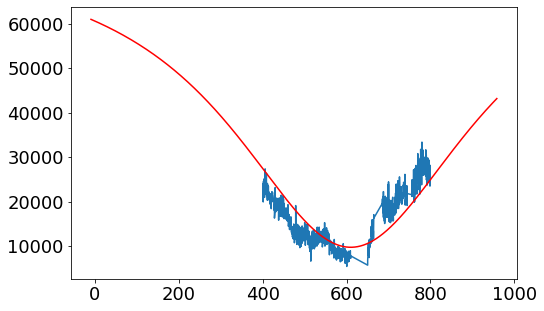

In [7]:
# Range of frequencies to filter out to remove SiV peaks
filter_range = [(-20, 400), (800, 1000), (610, 650), (665, 685), (745, 755)]

# Filter the freq and intensity values
filtered_indices = not_in_range(cavity_freqs, filter_range)
cavity_freqs_filtered = cavity_freqs[filtered_indices]
cavity_intensity_filtered = cavity_intensity[filtered_indices]

#####
params = Parameters()
params.add_many(
    Parameter('w_c', value=610, min=550, max=610),
    Parameter('k_in', value=100, min=0, max=1000),
    Parameter('k_tot', value=200, min=0, max=1000),
    Parameter('A', value=30000, min=10000, max=100000),
    Parameter('B', value=0, vary=False),
)

cavity_filtered_results = cavity_ref_model.fit(cavity_intensity_filtered, params, w=cavity_freqs_filtered, method="lbfgsb")
lmfit.report_fit(cavity_filtered_results)

plt.plot(cavity_freqs_filtered, cavity_intensity_filtered)
plt.plot(cavity_freqs, cavity_ref_model.eval(params=cavity_filtered_results.params, w=cavity_freqs), 'r')

## Tilted Cavity

In [8]:
def tilted_cavity_ref(w, w_c, k_in, k_tot, A, B, m):
    return (m * (w - w_c) + A) * Cavity.reflectance_fn(
                        w, -1, 0, 0, 0,
                        0, 0, 0,
                        w_c, k_in, k_tot
                        ) + B

tilted_cavity_ref_model = lmfit.Model(tilted_cavity_ref)

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 190
    # data points      = 3855
    # variables        = 4
    chi-square         = 3.4021e+10
    reduced chi-square = 8834311.23
    Akaike info crit   = 61661.4604
    Bayesian info crit = 61686.4889
[[Variables]]
    w_c:    610 (fixed)
    k_in:   30.2443332 +/- 0.42000094 (1.39%) (init = 100)
    k_tot:  127.231511 +/- 2.36294828 (1.86%) (init = 200)
    A:      29043.2803 +/- 145.776574 (0.50%) (init = 30000)
    B:      0 (fixed)
    m:      18.1375223 +/- 0.25417949 (1.40%) (init = 0.1)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, A)     =  0.834
    C(k_tot, A)    =  0.777
    C(k_in, k_tot) =  0.688
    C(A, m)        =  0.677
    C(k_in, m)     =  0.543
    C(k_tot, m)    =  0.492


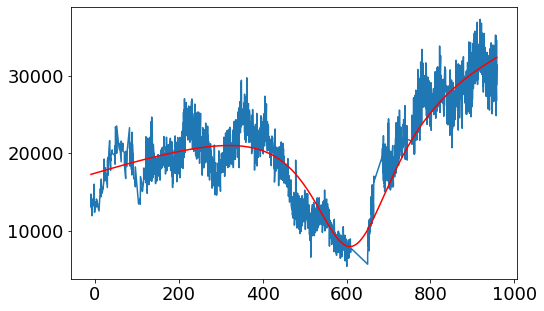

In [23]:
# Range of frequencies to filter out to remove SiV peaks
filter_range = [(610, 650), (665, 685), (745, 755)]
# filter_range = [(-20, 400), (800, 1000), (610, 650), (665, 685), (745, 755)]

# Filter the freq and intensity values
filtered_indices = not_in_range(cavity_freqs, filter_range)
cavity_freqs_filtered = cavity_freqs[filtered_indices]
cavity_intensity_filtered = cavity_intensity[filtered_indices]

#####
params = Parameters()
params.add_many(
    Parameter('w_c', value=610, vary=False),
    Parameter('k_in', value=100, min=0, max=1000),
    Parameter('k_tot', value=200, min=0, max=1000),
    Parameter('A', value=30000, min=10000, max=75000),
    Parameter('B', value=0, vary=False),
    Parameter('m', value=0.1, min=0, max=50),
)

cavity_filtered_results = tilted_cavity_ref_model.fit(cavity_intensity_filtered, params, w=cavity_freqs_filtered, method="lbfgsb")
lmfit.report_fit(cavity_filtered_results)

plt.plot(cavity_freqs_filtered, cavity_intensity_filtered)
plt.plot(cavity_freqs, tilted_cavity_ref_model.eval(params=cavity_filtered_results.params, w=cavity_freqs), 'r')

# Old Cavity Scan

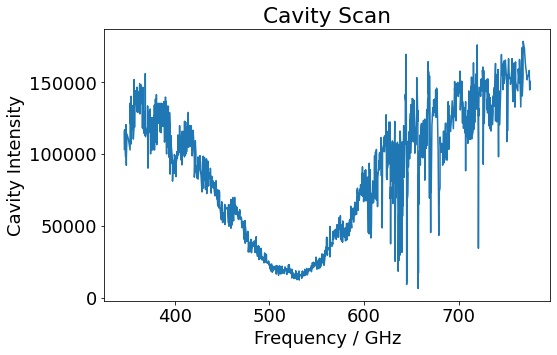

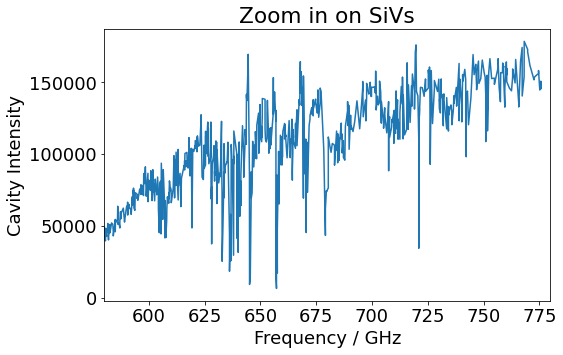

In [10]:
old_cavity_path = "../data/20210428_Bb02_cavity/"

old_cavity_files = ["bb2_2ndbacktune_raw-counts_x_15_58_47.txt", "bb2_2ndbacktune_raw-counts_15_58_47.txt"]
plt.figure(figsize=[8, 5])

old_cavity_freqs = np.loadtxt(old_cavity_path + old_cavity_files[0])
old_cavity_intensity = np.loadtxt(old_cavity_path + old_cavity_files[1])

old_cavity_freqs = 1000 * (old_cavity_freqs - 406) # Re-center, convert to GHz
plt.plot(old_cavity_freqs, old_cavity_intensity)
plt.xlabel("Frequency / GHz")
plt.ylabel("Cavity Intensity")
plt.title("Cavity Scan")

plt.figure(figsize=[8, 5])
plt.plot(old_cavity_freqs, old_cavity_intensity)
plt.xlim(580, 780)
plt.xlabel("Frequency / GHz")
plt.ylabel("Cavity Intensity")
plt.title("Zoom in on SiVs")


old_cavity_freqs, old_cavity_intensity = np.array(old_cavity_freqs), np.array(old_cavity_intensity)

[[Fit Statistics]]
    # fitting method   = L-BFGS-B
    # function evals   = 175
    # data points      = 1424
    # variables        = 4
    chi-square         = 1.7538e+11
    reduced chi-square = 1.2351e+08
    Akaike info crit   = 26535.7062
    Bayesian info crit = 26556.7511
[[Variables]]
    w_c:    524.205123 +/- 0.44135596 (0.08%) (init = 520)
    k_in:   63.7537232 +/- 1.19576975 (1.88%) (init = 100)
    k_tot:  98.6030067 +/- 1.54287695 (1.56%) (init = 200)
    A:      169998.065 +/- 1407.40770 (0.83%) (init = 150000)
    B:      0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(k_in, k_tot) =  0.972
    C(k_tot, A)    =  0.889
    C(k_in, A)     =  0.803


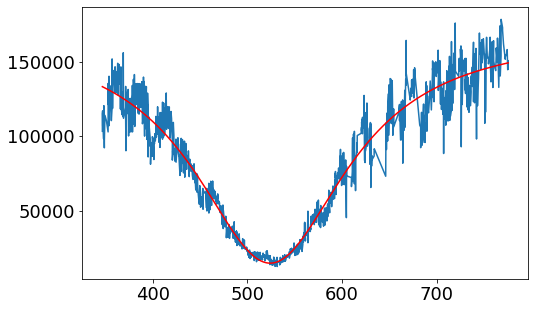

In [11]:
# Range of frequencies to filter out to remove cavity tails
filter_range = [(605, 610), (617, 620), (627, 629), (632, 634), (635, 646), (655, 660), (668, 672), (678, 682), (720, 723)]

# Filter the freq and intensity values
filtered_indices = not_in_range(old_cavity_freqs, filter_range)
old_cavity_freqs_filtered = old_cavity_freqs[filtered_indices]
old_cavity_intensity_filtered = old_cavity_intensity[filtered_indices]

#####
params = Parameters()
params.add_many(
    Parameter('w_c', value=520, min=500, max=550),
    Parameter('k_in', value=100, min=0, max=1000),
    Parameter('k_tot', value=200, min=0, max=1000),
    Parameter('A', value=150000, min=100000, max=250000),
    Parameter('B', value=0, vary=False),
)

old_cavity_filtered_results = cavity_ref_model.fit(old_cavity_intensity_filtered, params, w=old_cavity_freqs_filtered, method="lbfgsb")
lmfit.report_fit(old_cavity_filtered_results)

plt.plot(old_cavity_freqs_filtered, old_cavity_intensity_filtered)
plt.plot(old_cavity_freqs, cavity_ref_model.eval(params=old_cavity_filtered_results.params, w=old_cavity_freqs), 'r')